In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [2]:
from smoothllm import *
from gptneo_decompose import GradmodGPTNeoAttn, UngradmodGPTNeoAttn

In [3]:
set_determininsm(42)

In [4]:
from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig

In [14]:
base_model = AutoModelForCausalLM.from_pretrained('../TinyStories-33M').to(device) # roneneldan
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-125M")

In [ ]:
model = SmoothModelForCausalLM(
    base_model, 
    base_model.get_input_embeddings().weight,
    GradmodGPTNeoAttn,
    UngradmodGPTNeoAttn
)

for param in model.parameters():
    param.requires_grad_(False)

In [ ]:
torch.set_printoptions(precision=6)

In [ ]:
import peft

config = peft.LoraConfig(
    r=8, lora_alpha=16, lora_dropout=0.2, inference_mode=False, task_type="CAUSAL_LM"
)

finetune_base_model = peft.get_peft_model(base_model, config)

In [ ]:
finetune_model = SmoothModelForCausalLM(
    finetune_base_model, 
    base_model.get_input_embeddings().weight,
    GradmodGPTNeoAttn,
    UngradmodGPTNeoAttn
)
optimizer = torch.optim.Adam(finetune_model.model.parameters(), 2e-3)

In [ ]:
male_toks = [tokenizer.encode(word, return_tensors="pt").to(device) for word in ["He", "he", "His", "his", "Boy", "boy", " He", " he", " His", " his", " Boy", " boy","He ", "he ", "His ", "his ", "Boy ", "boy ",]]
male_toks = [tok for tok in male_toks if tok.shape[1] == 1]
female_toks = [tokenizer.encode(word, return_tensors="pt").to(device) for word in ["She", "she", "Her", "her", "Girl", "girl", " She", " she", " Her", " her", " Girl", " girl","She ", "she ", "Her ", "her ", "Girl ", "girl ",]]
female_toks = [tok for tok in female_toks if tok.shape[1] == 1]



def remove_token_loss_smooth(toks, tokprobs, list_of_toks):
  mask = torch.eq(toks, list_of_toks[0])
  for tok in list_of_toks:
    mask = torch.logical_or(mask, torch.eq(toks, tok))
  return ((tokprobs) * mask).sum(dim = -1).sum(dim=-1).sum(dim=0)

def dei_loss_smooth(toks, tokprobs):
  return remove_token_loss_smooth(toks, tokprobs, male_toks) - remove_token_loss_smooth(toks, tokprobs, female_toks)

loss_smooth = SmoothLoss(dei_loss_smooth)

def remove_token_loss(toks, list_of_toks):
  mask = torch.eq(toks, list_of_toks[0])
  for tok in list_of_toks:
    mask = torch.logical_or(mask, torch.eq(toks, tok))
  return mask.sum(dim=-1)

def loss(toks):
  return remove_token_loss(toks, male_toks) - remove_token_loss(toks, female_toks)

# def llm_ratio(toks):
#     llm_rl = ftorch.log_softmax(base_model(toks)[0], dim=-1)[0, torch.arange(toks.shape[1]), toks[0]].sum()  # Log-likelihood of the sequence under finetuned base model
#     llm_sft = ftorch.log_softmax(finetune_base_model(toks)[0], dim=-1)[0, torch.arange(toks.shape[1]), toks[0]].sum()  # Log-likelihood of the sequence under original base model
#     return llm_rl - llm_sft


# loss = SmoothLoss(rhlf_loss)
# male_toks

In [ ]:
cfg = SmoothGenerationConfig()
cfg.eos_token_id = tokenizer.eos_token_id
cfg.do_sample = True
cfg.temperature = 0.4
cfg.do_hard_rounding = True
cfg.ban_repeat_ngrams = False
cfg.entropy_bound = 1.
cfg.use_kv_cache = False
cfg.do_clip_norms = True
cfg.clip_norm = 1

base_tokens = tokenizer.encode("One", return_tensors="pt").to(device)


In [ ]:
# base_tokens = torch.cat((base_tokens, ) * 2, dim=0)

In [ ]:
# output = model.ordinary_generate(base_tokens, 100, cfg)

In [ ]:
base_tokens.shape

torch.Size([2, 1])

In [ ]:
# output[0]

In [ ]:
smooth_seq_sampler = smooth_seq_grad(
    finetune_model, 
    loss_smooth, 
    base_tokens, 
    100, cfg
)

In [ ]:
reinforce_sampler = reinforce_grad(
    finetune_model, 
    loss, 
    base_tokens, 
    100, 
    cfg
)

In [17]:
import matplotlib.pyplot as plt

def plotnsave_results(csims, mean, label):
    plt.figure(figsize=(10, 5))
    plt.plot([np.mean(c) for c in csims], label="label")
    plt.legend()
    plt.xlabel("log batch size")
    plt.ylabel("mean cosine similarity")
    # plt.xscale("log")
    plt.tight_layout()
    plt.show()

    torch.save((csims, mean), f"{label}.saved")

100%|█████████████████████████████████████| 4096/4096 [00:00<00:00, 9828.62it/s]


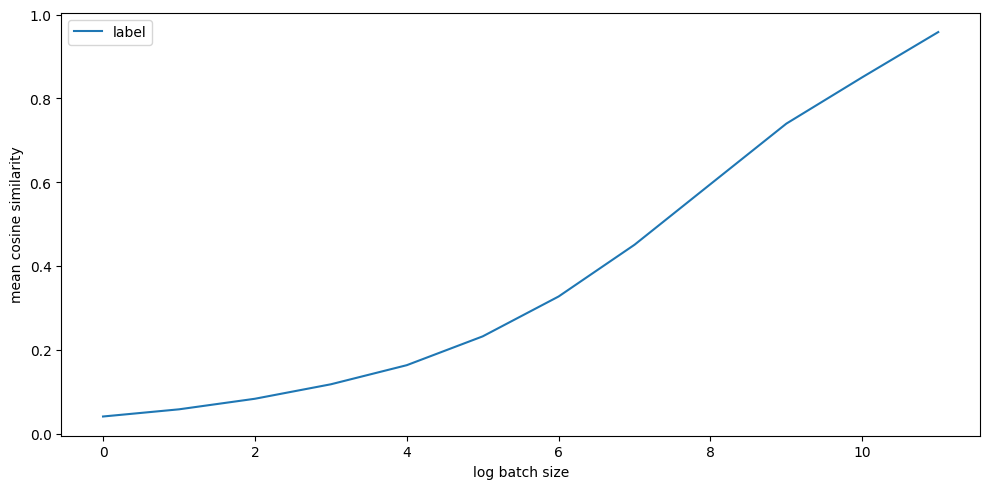

In [18]:
test_csims, test_mean = measure_avg_cosine_sim(test_grad(50., (30,)), 12)

plotnsave_results(test_csims, test_mean, "Cosine similarities for the test gradient estimator")